In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import pandas as pd
df = pd.read_csv('../ca2015_all_csv_v1.txt', na_values='*'  )
ent = pd.read_csv('../ca2015entities_csv.txt')

df = df[df['Test Id'] == 1]

def f(x):
    return "{:02d}{:05d}{:07d}".format(x['County Code'],x['District Code'],x['School Code'])
   
df['cds'] = df.apply(f, axis=1)
ent['cds'] = ent.apply(f, axis=1)
ent.set_index('cds',inplace = True)

county_names = ent['County Name']
school_names = ent['School Name']
district_names = ent[['District Name', 'County Name']]

race_eth_subgroups = [200,202,203,204,206]+[220, 222, 223, 224, 226]
race_eth_names = ['BlackED', 'AsianED', 'FilipinoED' , 'LatinoED', 'WhiteED', 
                    'BlackP', 'AsianP', 'FilipinoP' , 'LatinoP', 'WhiteP']


subgroups = pd.read_csv('../Subgroups.txt', header=None, names = ['subgroup_id','subgroup_name','category'],
                       index_col = 0)
subgroups['title'] = subgroups.apply(lambda row: row['category']+"; "+row['subgroup_name'], axis=1)
subgroup_names = subgroups.to_dict()['title']

df['pct_subgroup'] = df['Total Tested At Subgroup Level'] / df['Total Tested At Entity Level']

In [20]:
def geo_decomp(grade):
    def subset(grade, df):
        
        
        dfs = df[['cds', 'County Code', 'Subgroup ID', 'pct_subgroup', 'Grade','Mean Scale Score', 
             'Percentage Standard Met and Above']]
        dfs.columns = [u'cds', 'county',  u'subgroup', u'pct_subgroup', u'grade', u'mss', u'pct_msa']

        return dfs[dfs.grade == grade]

    schools = subset(grade, df[df['School Code'] != 0])
    districts =  subset(grade, df[(df['District Code'] != 0) & (df['School Code'] == 0)])
    counties =  subset(grade, df[ (df['County Code'] != 0) & (df['District Code'] == 0) & (df['School Code'] == 0)])
    states =  subset(grade, df[ (df['County Code'] == 0)])

    counties_p = pd.pivot_table(counties,index='cds', columns='subgroup', values='pct_msa')
    districts_p = pd.pivot_table(districts[districts.pct_msa != 0],index='cds', columns='subgroup', values='pct_msa')
    schools_p = pd.pivot_table(schools[schools.pct_msa != 0],index='cds', columns='subgroup', values='pct_msa')
    
    return (states, counties, counties_p, districts, districts_p, schools, schools_p)
   
def munge_sg_cols(df):
    df.columns = [ subgroup_names.get(e,e).strip().strip('"') for e in df.columns ]
    return df
    

In [21]:
state, counties, counties_p, districts, districts_p, schools, schools_p = geo_decomp(3)

In [102]:
def sg_cross(subgroups):
    d = schools[schools.subgroup.isin(subgroups)].set_index(['cds','subgroup'])[['pct_subgroup','pct_msa']]
    e = d.unstack(1)
    e.columns = [ "{}_{}".format(*c) for c in e.columns.values]
    return e

def fit_plot(x_sg, y_sg):
    """Scatter plot and regression line for how % proficient for subgroup 2 changes
    in response to subgroup 1"""
    import matplotlib.pyplot as plt
    # fit with np.polyfit
    e = sg_cross((x_sg, y_sg))
    e = e.dropna()
    x = e['pct_subgroup_{}'.format(x_sg)]
    y = e['pct_msa_{}'.format(y_sg)]
    m, b = np.polyfit(x,y, 1)

    plt.plot(x, y, '.')
    plt.plot(x, m*x + b, '-')


In [ ]:
e = sg_cross((1,204))
e.plot(kind='scatter', x='pct_subgroup_204' , y='pct_msa_1', figsize=(20,20))

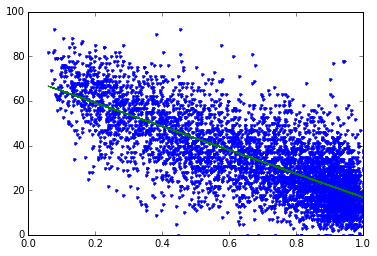

In [97]:

fit_plot(31, 1) # Whole school vs % ED

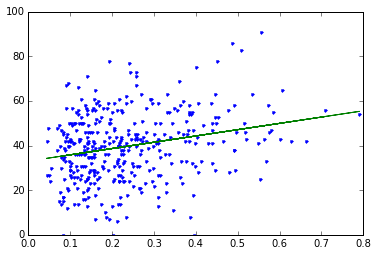

In [98]:
fit_plot(222, 31) # Economically disadvantaged vs % asian

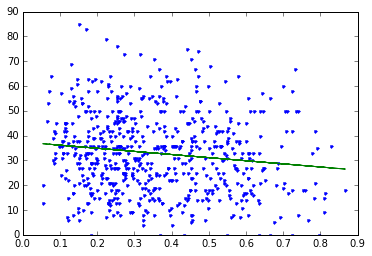

In [100]:
fit_plot(204, 206) # ED Whites vs % ED Hispanic

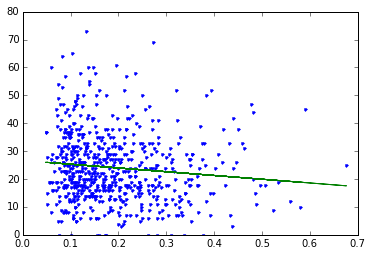

In [101]:
fit_plot(206, 204) # ED hispanic vs % ED whites

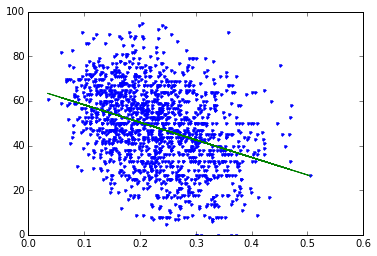

In [104]:
fit_plot(91, 93) # College parent vs % HS parent

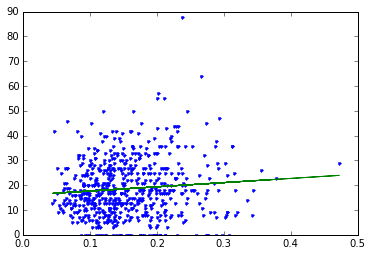

In [106]:
fit_plot(93, 90) 